# ASR-CL
## Lucida AI Evaluation

### Goal
Investigate the relationship between the errors of ASR (Automatic Speech Recognition) and the errors of CL (Classifier for query).

### Generate Quries from Original Data

100 sentences on QA (Generic QA; from a public dataset) and 100 sentences on CA (Calendar; hand-made).

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re, string, sys, json
from random import randrange
from operator import itemgetter
import matplotlib.pyplot as plt
fig = plt.figure()
plt.rc("font", family="serif")
plt.rc("font", size=15)

In [2]:
# Return true if the string contains any of the characters in the set.
def contains_any(str, set):
    return 1 in [c in str for c in set]

# Generate 100 queires from the original data file
# 'dev-v1.1.json'.
# Format: JSON.
# Print out the queries.
# Data source: https://rajpurkar.github.io/SQuAD-explorer/.
def generate_100_queires():
    with open('dev-v1.1.json') as json_data:
        d = json.load(json_data)
    count = 0
    while True:
        seen = {}
        if count >= 100:
            break
        data = d['data'][randrange(len(d['data']))]
        paragraph = data['paragraphs'][randrange(len(data['paragraphs']))]
        qa = paragraph['qas'][randrange(len(paragraph['qas']))]
        query = qa['question']
        if query in seen or contains_any(query[:-1], string.punctuation) \
        or not '?' in query or len(query.split()) < 7 or '  ' in query:
            continue
        seen[query] = 1
        print(query)
        count += 1

# Label the first `first_part` queries as `QA`, and the rest as `CA`.
# Print the label transcripts.
def label_transcript(transcript_file_path, first_part):
    print('query,answer')
    file = open(transcript_file_path)
    lines= file.readlines()
    file.close()
    for i, line in enumerate(lines):
        line = line.rstrip('\n')
        if ',' in line:
            line = '"' + line + '"'
        print(line + ',' + ('QA' if i < first_part else 'CA'))
    
# generate_100_queires() # save the result to 'speech/transcript.txt'
# label_transcript('speech/transcript.txt', 100)

### Generate Raw Data by Sending Queries to the Pipeline

### Generate DataFrame from ASR Results

In [3]:
# Return a DataFrame from the file with the following format:
# <audio_path>,<transcript>
# in which the audio path is of the following format:
# "path/to/file/<query_id>_<text>.wav"
# An example file:
# ../asr_cl/speech/0_Helloworld.wav,"hello world."
# Its first line must have be the header!
# The DataFrame has only one column: transcript
# with the specified header
# and sorted by the query id.
def get_df_from_asr_result(file_path, header):
    file = open(file_path, 'r')
    lines = file.readlines()
    lines.pop(0) # pop the header
    file.close()
    proc_lines = []
    for line in lines:
        line = line.lstrip().rstrip('\n')
        # The first occurrence of a number is assumed to be the query id.
        id = int(re.search(r'\d+', line).group())
        transcript = line.split(',')[1]
        if transcript.startswith('"') and transcript.endswith('"'):
            transcript = transcript[1:-1]
        proc_lines.append((id, transcript))
    proc_lines.sort(key=itemgetter(0)) # sort data by ID
    df = pd.DataFrame([row[1] for row in proc_lines], columns=[header])
    return df

data = pd.read_csv('text/query.txt')

asr_labels = ['fisher', 'librispeech', 'tedlium']

for asr_label in asr_labels:
    data = data.join \
    (get_df_from_asr_result('asr_result_{}.txt'.format(asr_label), \
                            'transcript_{}'.format(asr_label)))

In [4]:
# Return a DataFrame from CL result data.
# In order to match the query in the CL result data
# to the query in `data`,
# the column name to match should be specified.
def get_df_from_cl_result(cl_label, data, match_col):
    cl_data = pd.read_csv('cl_result_{}.txt'.format(cl_label))
    results = []
    cl_data[:]
    for j, asr_output in enumerate(data[match_col]):
        match_row = -1
        if asr_output != '':
            for i, cl_input in enumerate(cl_data['query']):
                if cl_input == asr_output:
                    match_row = i
                    break
            if match_row == -1:
                raise RuntimeError('Cannot find the query ' + asr_output)
            result = cl_data['result'].ix[match_row]
        else:
            result = None # ASR did not return any result, so CL must be wrong!
        if 'QA' in result:
            result = 'QA'
        elif 'CA' in result:
            result = 'CA'
        else:
            raise RuntimeError('Unrecognized result ' + result)
        results.append((j, result))
    assert(len(results) == data.shape[0])
    results.sort(key=itemgetter(0)) # sort data by row index
    df = pd.DataFrame({'answer_{}'.format(cl_label): [row[1] for row in results]})
    return df
    
cl_labels = [('fisher_svc', 'transcript_fisher'), \
             ('fisher_randomforest', 'transcript_fisher'), \
             ('librispeech_svc', 'transcript_librispeech'), \
             ('librispeech_randomforest', 'transcript_librispeech'), \
             ('tedlium_svc', 'transcript_tedlium'), \
             ('tedlium_randomforest', 'transcript_tedlium'), \
             ('regular_svc', 'query'), \
             ('regular_randomforest', 'query')]

for cl_label, match_col in cl_labels:
    data = data.join \
    (get_df_from_cl_result(cl_label, data, match_col), lsuffix='')
data = data[['query', 'answer', \
             'answer_regular_svc', 'answer_regular_randomforest', \
             'transcript_fisher', \
             'answer_fisher_svc', 'answer_fisher_randomforest', \
             'transcript_librispeech', \
             'answer_librispeech_svc', 'answer_librispeech_randomforest', \
             'transcript_tedlium', \
             'answer_tedlium_svc', 'answer_tedlium_randomforest']]
data.to_csv('data.txt') # save to disk

### Observation

In [5]:
from IPython.display import display
pd.set_option('display.max_colwidth', -1) # display full text
data = pd.read_csv('data.txt', index_col=0)
pd.set_option('display.max_columns', data.shape[1]) # display all columns
data[:]

,query,answer,answer_regular_svc,answer_regular_randomforest,transcript_fisher,answer_fisher_svc,answer_fisher_randomforest,transcript_librispeech,answer_librispeech_svc,answer_librispeech_randomforest,transcript_tedlium,answer_tedlium_svc,answer_tedlium_randomforest
0,What party had a victory in the 2015 UK election?,QA,QA,QA,what party had a victory and she'll and says it's election.,QA,QA,WHAT PART HE HAD A VICTORY AND THE TWO L ONE FIVE OF COLLECTION.,QA,QA,what party had a vegetarian that show and five election.,QA,QA
1,What is the main difference between online pharmacies and community pharmacies?,QA,QA,QA,what is the main difference between online pharmacies and community pharmacies.,QA,QA,WHAT IS THE MAIN DIFFERENCE BETWEEN ONLINE PHARMACIES AND COMMUNITY PHARMACIES.,QA,QA,what is the main difference between online pharmacies and community pharmacies.,QA,QA
2,What type of treatment are pharmacists important for?,QA,QA,QA,what type of treatments are pharmacists important for.,QA,QA,WHAT TYPE OF TREATMENT ARE PHARMACISTS IMPORTANT FOR.,QA,QA,what type of treatment are pharmacists important for.,QA,QA
3,Who did Genghis Khan unite before he began conquering the rest of Eurasia?,QA,QA,QA,it changes fun unite before he began time during the rest of your asia.,QA,QA,THEIR GENGHIS KHAN UNITE BEFORE HE BEGAN CONQUERING THE REST OF EURASIA.,QA,QA,the chain has been unite before he began found carrying the rest of your asia.,QA,QA
4,In what year was HMS Dreadnought launched?,QA,QA,QA,right yeah lessons trying not launched.,QA,QA,AND WHAT YEAR WAS HIS DREAD NOT LAUNCHED.,QA,QA,what year was instead not launched.,QA,QA
5,What cytokines are responsible for communication between white blood cells?,QA,QA,QA,let's say looking you sorry sponsel for communication between like blood cells.,QA,QA,WHAT SAID OPINIONS ARE RESPONSIBLE FOR COMMUNICATION BETWEEN WHITE BLOOD SELVES.,QA,QA,what set of genes are responsible for communication between white blood cells.,QA,QA
6,What are some proposals to connect campuses?,QA,QA,QA,what are some proposals to connect campuses.,QA,QA,WHAT ARE SOME PROPOSALS TO CONNECT CANVASES.,QA,QA,but are some proposals to connect campuses.,QA,QA
7,What compounds can be masked with the molecules of the host cell in order for a virus to evade detection?,QA,QA,QA,well sometimes can be messed with the knowledge ills of the hosts cell in order for virus to invade detection.,QA,QA,WHAT COMPOUNDS CONVENE ASKED FOR THE MOLECULES OF THE HOST SELLIN ORDER FOR A VIRUS TO EVADE DETECTION.,QA,QA,what from fans can be messed with the molecules of the host cell in order for a virus to evade detection.,QA,QA
8,Where did the residents of Antioch flee to?,QA,QA,QA,where did the residents of and she actually too.,QA,QA,WHERE DID THE RESIDENCE OF ANTIOCH FLEE TO.,QA,QA,where did the residents of antioch fleets to.,QA,QA
9,Who designed the garden for the University Library?,QA,QA,QA,design the garden for the university library.,QA,QA,IT IS EYEING THE GARDEN FOR THE UNIVERSITY LIBRARY.,QA,QA,he designed the garden for the university library.,QA,QA


### Collect Statistics and Plot

### Plot SVC Performance

1. Baseline is SVC with the original text query
2. Score is relative to the baseline:
    - If the baseline is correct but the ASR causes it to be wrong, the score is -2
    - If the baseline is correct and the ASR does not change the result, the score is +1
    - If the baseline is wrong and the ASR does not change the result, the score is -1
    - If the baseline is wrong but the ASR causes it to be correct, the score is +2

In [6]:
sys.path.append('../../asr')
from wer import error_rate

# Return true if the answer is the same as the correct answer.
# Return false otherwise.
def answer_is_correct(answer, correct_answer):
    return answer == correct_answer

# Analyze the data for the specified ASR and return the statistics.
def analyze(data, asr_name, cl_name, verbose=True):
    size = data.shape[0]
    asr_errors = np.zeros(size)
    for j, transcript in enumerate(data['_'.join(['transcript', asr_name])]):
        asr_errors[j] = error_rate(data['query'][j], transcript)
    scores = np.zeros(size)
    relative_scores = np.zeros(size)
    regular_cl_result = np.zeros(size)
    cl_result = np.zeros(size)
    for j, answer in enumerate(data['_'.join(['answer', asr_name, cl_name])]):
        correct_answer = data['answer'][j]
        regular_answer = data['_'.join(['answer', 'regular', cl_name])][j]
        if answer_is_correct(regular_answer, correct_answer):
            # Regualr is correct.
            regular_cl_result[j] = 1
            if not answer_is_correct(answer, correct_answer):
                # Become wrong.
                scores[j] = 0
                relative_scores[j] = -2
            else:
                # Still correct.
                scores[j] = 1
                relative_scores[j] = 1
                cl_result[j] = 1
        else:
            # Regular is wrong.
            if not answer_is_correct(answer, correct_answer):
                # Still wrong.
                scores[j] = 0
                relative_scores[j] = -1
            else:
                # Become correct!
                scores[j] = 1
                relative_scores[j] = 2
                cl_result[j] = 1
                
    if verbose:
        wrong_indices = []
        for i, result in enumerate(cl_result):
            if result == 0:
                wrong_indices.append(i)
        print(wrong_indices)
    avg_cl_accuracy = np.count_nonzero(cl_result) / cl_result.size
    avg_regular_cl_accuracy = np.count_nonzero(regular_cl_result) / regular_cl_result.size
    print('avg_asr_error:', asr_errors.mean(), \
          'avg_cl_accuracy:', avg_cl_accuracy, \
          'avg_regular_cl_accuracy', avg_regular_cl_accuracy)
    return {'asr_name': asr_name, 'cl_name': cl_name, \
            'asr_errors': asr_errors, \
            'avg_asr_error': asr_errors.mean(), \
            'relative_scores': relative_scores, \
            'regular_cl_result': regular_cl_result, 'cl_result': cl_result, \
            'avg_cl_accuracy': avg_cl_accuracy, \
            'avg_regular_cl_accuracy': avg_regular_cl_accuracy}

# Plot the relative scores vs error rates for a particular ASR+CL combination.
def plot_score_vs_error(color, asr_name, cl_name, asr_errors, relative_scores, **extras):
    plt.xlabel('ASR Error Rate')
    plt.ylabel('CL Relative Score')
    plt.title(' '.join([asr_name, cl_name]))
    plt.scatter(asr_errors, relative_scores, label=asr_name, color=color)

[22, 61, 94, 100, 101, 102, 104, 111, 112, 115, 116, 117, 121, 122, 123, 124, 125, 126, 127, 130, 133, 135, 136, 140, 141, 143, 145, 149, 153, 154, 159, 160, 161, 163, 165, 166, 167, 168, 170, 171, 172, 174, 175, 176, 177, 178, 181, 182, 184, 185, 186, 187, 188, 190, 191, 192, 195, 196, 198, 199]
avg_asr_error: 0.760206736552 avg_cl_accuracy: 0.7 avg_regular_cl_accuracy 0.74


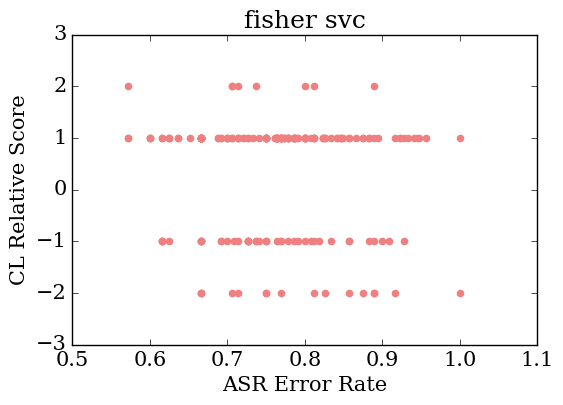

In [7]:
svc_stats_list = []
svc_stats_list.append(analyze(data, 'fisher', 'svc'))
plot_score_vs_error('lightcoral', **svc_stats_list[-1])

[61, 99, 100, 101, 103, 104, 108, 110, 111, 112, 116, 118, 119, 121, 122, 123, 125, 126, 127, 130, 132, 133, 135, 136, 137, 140, 141, 143, 153, 154, 155, 158, 159, 160, 161, 163, 167, 168, 170, 171, 172, 173, 174, 176, 177, 178, 181, 182, 183, 184, 185, 187, 188, 190, 192, 194, 195, 196, 198, 199]
avg_asr_error: 0.701972231532 avg_cl_accuracy: 0.7 avg_regular_cl_accuracy 0.74


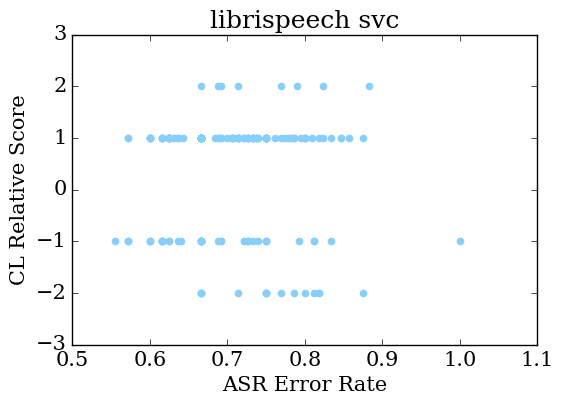

In [8]:
svc_stats_list.append(analyze(data, 'librispeech', 'svc'))
plot_score_vs_error('lightskyblue', **svc_stats_list[-1])

[61, 86, 104, 110, 111, 112, 116, 117, 119, 121, 123, 124, 125, 126, 127, 130, 132, 133, 134, 135, 136, 137, 140, 141, 143, 146, 148, 149, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 165, 167, 168, 170, 172, 173, 174, 175, 176, 177, 178, 181, 182, 184, 185, 187, 188, 190, 192, 195, 196, 198, 199]
avg_asr_error: 0.720415652129 avg_cl_accuracy: 0.695 avg_regular_cl_accuracy 0.74


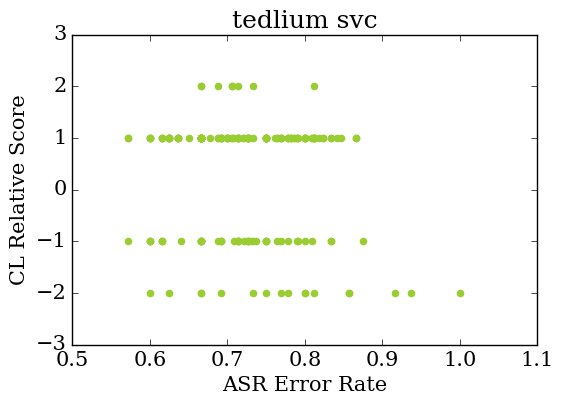

In [9]:
svc_stats_list.append(analyze(data, 'tedlium', 'svc'))
plot_score_vs_error('yellowgreen', **svc_stats_list[-1])

In [10]:
# Return the data from the list of CL statistics (one for each ASR model).
def gather_data_for_cl_vs_asr(stats_list):
    asr_name_list = [stats['asr_name'] for stats in stats_list]
    avg_asr_accuracy_list = [1 - stats['avg_asr_error'] for stats in stats_list]
    avg_cl_accuracy_list = [stats['avg_cl_accuracy'] for stats in stats_list]
    avg_regular_cl_accuracy_list = \
    [stats['avg_regular_cl_accuracy'] for stats in stats_list]
    avg_cl_accuracy_drop_list = \
    [stats['avg_cl_accuracy'] - avg_regular_cl_accuracy_list[i] \
     for i, stats in enumerate(stats_list)]
    avg_cl_accuracy_drop_percentage_list = \
    [ (avg_cl_accuracy_drop / avg_regular_cl_accuracy_list[i]) * 100 \
     for i, avg_cl_accuracy_drop in enumerate(avg_cl_accuracy_drop_list)]
    return asr_name_list, avg_asr_accuracy_list, avg_cl_accuracy_list, \
avg_regular_cl_accuracy_list, avg_cl_accuracy_drop_list, \
avg_cl_accuracy_drop_percentage_list

# Plot the performance of a particular CL under the influence of different ASR models.
def plot_cl_vs_asr(stats_list, cl_name, color):  
    assert(len(stats_list) != 0)
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average CL Accuracy')
    plt.title('Performace of {}\n under the influence of ASR'.format(cl_name))
    # Gather data.
    asr_name_list, avg_asr_accuracy_list, avg_cl_accuracy_list, \
    avg_regular_cl_accuracy_list, \
    avg_cl_accuracy_drop_list, avg_cl_accuracy_drop_percentage_list = \
    gather_data_for_cl_vs_asr(stats_list)
    # Plot.
    plt.scatter(avg_asr_accuracy_list, avg_cl_accuracy_list, color=color)
    for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
        txt = '{}\n({:.2f},{:.3f})\n$\Delta$Accuracy={:.3f}\n({:.2f}%)'.format \
        (asr_name_list[i], avg_asr_accuracy, avg_cl_accuracy_list[i], \
         avg_cl_accuracy_drop_list[i], \
         avg_cl_accuracy_drop_percentage_list[i])
        plt.annotate(txt, (avg_asr_accuracy, avg_cl_accuracy_list[i]), \
                    fontsize=10)

# Plot the performance of a different CLs under the influence of different ASR models.
def plot_cls_vs_asr(list_of_stats_list, list_of_cl_name, list_of_colors):
    assert(len(list_of_stats_list) != 0)
    assert(len(list_of_stats_list[0]) != 0)
    assert(len(list_of_stats_list) == len(list_of_cl_name))
    assert(len(list_of_cl_name) == len(list_of_colors))
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average CL Accuracy')
    plt.title('Performace of {}\nunder the influence of ASR'. \
              format(', '.join(list_of_cl_name)))
    for i, stats_list in enumerate(list_of_stats_list):
        cl_name = list_of_cl_name[i]
        # Gather data.
        asr_name_list, avg_asr_accuracy_list, avg_cl_accuracy_list, \
        avg_regular_cl_accuracy_list, \
        avg_cl_accuracy_drop_list, avg_cl_accuracy_drop_percentage_list = \
        gather_data_for_cl_vs_asr(stats_list)
        # Plot.
        plt.scatter(avg_asr_accuracy_list, avg_cl_accuracy_list, \
                    label='{} with ASR'.format(cl_name), \
                    color=list_of_colors[i])
        xs = np.arange(0.22, 0.36, 0.02)
        plt.plot(xs, \
                 np.full(xs.shape, avg_regular_cl_accuracy_list[0]), \
                 'k--', color=list_of_colors[i], \
                 label='{} Regular'.format(cl_name))
        plt.legend(loc='best', fontsize=9)
        for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
            txt = '{}'.format(asr_name_list[i])
            plt.annotate(txt, (avg_asr_accuracy, avg_cl_accuracy_list[i]), \
                         fontsize=10)

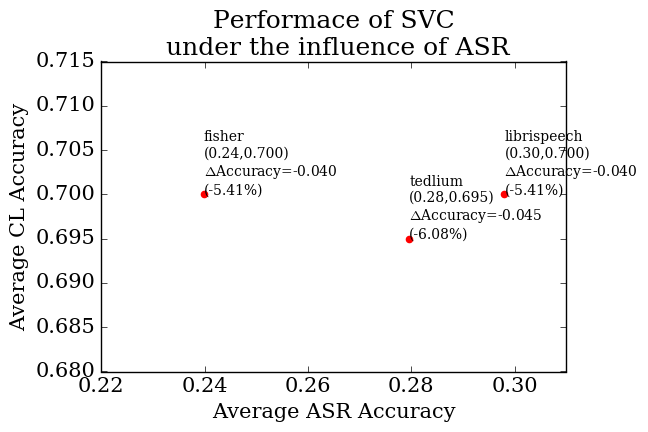

In [11]:
plot_cl_vs_asr(svc_stats_list, 'SVC', 'red')

### Plot Random Forest Performance

[100, 102, 104, 107, 110, 111, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 145, 148, 149, 151, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 190, 191, 192, 195, 196, 197, 198, 199]
avg_asr_error: 0.760206736552 avg_cl_accuracy: 0.62 avg_regular_cl_accuracy 0.67


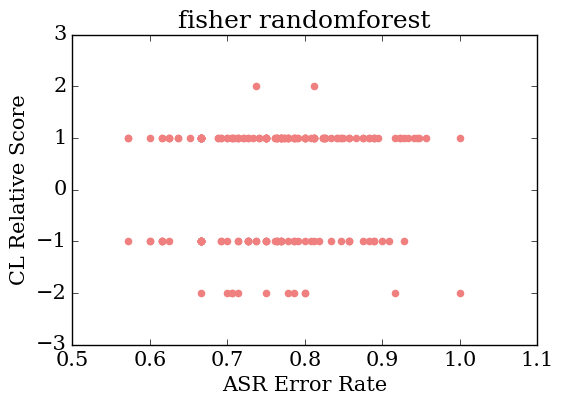

In [12]:
randomforest_stats_list = []
randomforest_stats_list.append(analyze(data, 'fisher', 'randomforest'))
plot_score_vs_error('lightcoral', **randomforest_stats_list[-1])

[100, 102, 103, 104, 108, 110, 111, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 140, 141, 143, 148, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 163, 164, 165, 167, 168, 170, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 187, 190, 191, 192, 195, 196, 198, 199]
avg_asr_error: 0.701972231532 avg_cl_accuracy: 0.645 avg_regular_cl_accuracy 0.67


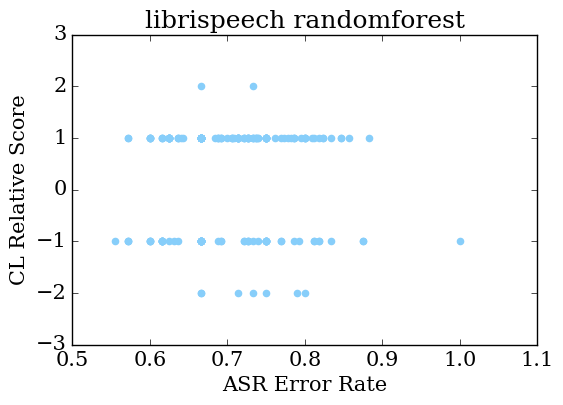

In [13]:
randomforest_stats_list.append(analyze(data, 'librispeech', 'randomforest'))
plot_score_vs_error('lightskyblue', **randomforest_stats_list[-1])

[102, 104, 110, 111, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 146, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 167, 168, 170, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 187, 190, 191, 192, 195, 196, 198, 199]
avg_asr_error: 0.720415652129 avg_cl_accuracy: 0.645 avg_regular_cl_accuracy 0.67


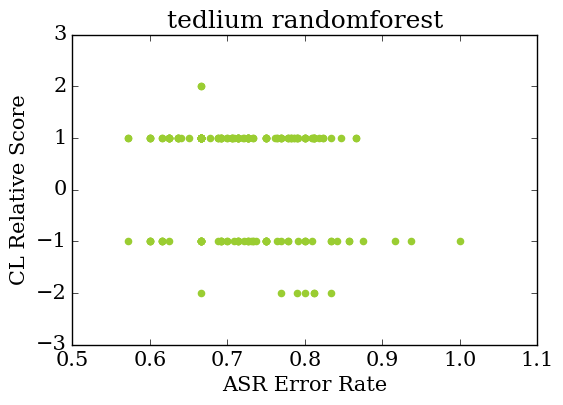

In [14]:
randomforest_stats_list.append(analyze(data, 'tedlium', 'randomforest'))
plot_score_vs_error('yellowgreen', **randomforest_stats_list[-1])

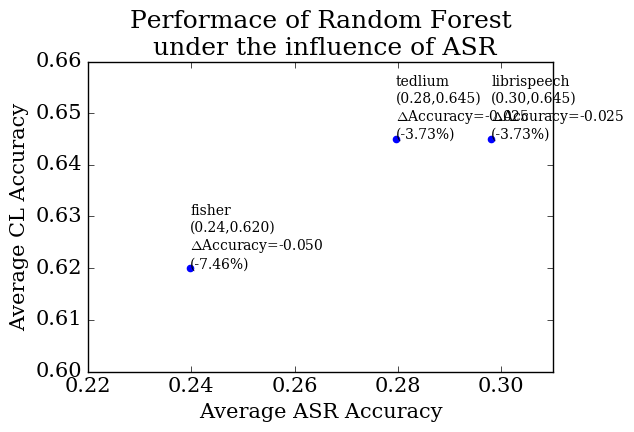

In [15]:
plot_cl_vs_asr(randomforest_stats_list, 'Random Forest', 'blue')

### Summary

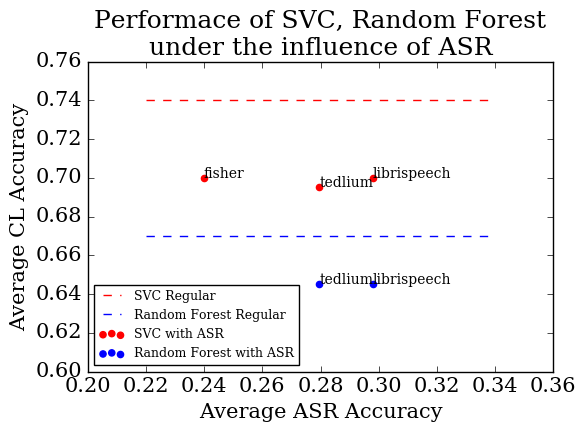

In [16]:
plot_cls_vs_asr([svc_stats_list, randomforest_stats_list], \
                ['SVC', 'Random Forest'], ['red', 'blue'])